# Statistical model with R

## Data Preparation

In [7]:
# Set library path
.libPaths("/net/scratch/schoelleh96/WP2/WP2.2a/RScripts/R_libs")

# List of required packages
required_packages <- c(
    "ncdf4", "tidync", "Matrix", "mgcv", "tidyr",
    "lubridate", "dplyr"
)

options(repos = c(CRAN = "https://cran.r-project.org"))

# Install missing packages and load libraries
missing_packages <- required_packages[
    !(required_packages %in% installed.packages()[, "Package"])
]
if (length(missing_packages) > 0) {
    install.packages(missing_packages,
        lib = "/net/scratch/schoelleh96/WP2/WP2.2a/RScripts/R_libs"
    )
}

# Load the required libraries
lapply(required_packages, require, character.only = TRUE)


[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

In [8]:
R.version.string


[1] "R version 4.2.2 Patched (2022-11-10 r83330)"

In [5]:
library(ncdf4)
library(gratia)
library(gamlss)
library(tidyr)
library(lubridate)
library(dplyr)
library(ggplot2)
library(mgcv)


In [114]:
library(tidync)
ncFile <- nc_open("../ens_data/data.nc")
dims <- tidync("../ens_data/data.nc")
print(dims$dimension)
length_value <- dims$dimension %>%
    filter(name == "time") %>%
    pull(length)
length_value


# A tibble: 4 × 8
     id name      length unlim coord_dim active start count
  <int> <chr>      <dbl> <lgl> <lgl>     <lgl>  <int> <int>
1     0 number        10 FALSE TRUE      TRUE       1    10
2     1 time       31013 FALSE TRUE      TRUE       1 31013
3     2 latitude     141 FALSE TRUE      TRUE       1   141
4     3 longitude    241 FALSE TRUE      TRUE       1   241


[1] 31013

In [1]:
# Open the NetCDF file
ncFile <- nc_open("../ens_data/data.nc")

print(ncFile)

z <- ncvar_get(
  ncFile,
  "z",
  start = c(1, 1, 1, 1),
  count = c(1, 1, 31013, 10)
)

nc_close(ncFile)
dim(z)


ERROR: Error in nc_open("../ens_data/data.nc"): konnte Funktion "nc_open" nicht finden


In [4]:
ncFile <- nc_open("../ens_data/data.nc")

time_dat <- ncvar_get(
  ncFile,
  "valid_time",
  start = 1,
  count = 31013
)
validTimeUnits <- ncatt_get(ncFile, "valid_time", "units")$value
timeOrigin <- sub("seconds since ", "", validTimeUnits) # Extract "1970-01-01"
print(timeOrigin)

# Convert to POSIXct format
time <- as.Date(as.POSIXct(time_dat, origin = timeOrigin, tz = "UTC"))
nc_close(ncFile)
head(time)
tail(time)


[1] "1970-01-01"


[1] "1940-01-01" "1940-01-02" "1940-01-03" "1940-01-04" "1940-01-05"
[6] "1940-01-06"

[1] "2024-11-22" "2024-11-23" "2024-11-24" "2024-11-25" "2024-11-26"
[6] "2024-11-27"

In [5]:
change_points <- c("1947-12", "1955-01", "1979-03", "1998-05")

# Convert to Date objects for easier comparison
change_points_date <- as.Date(as.POSIXct(paste0(change_points, "-01"),
  format = "%Y-%m-%d", tz = "UTC"
))

print(change_points_date)


[1] "1947-12-01" "1955-01-01" "1979-03-01" "1998-05-01"


In [6]:
z_df <- data.frame(time = time, z = z)
z_df$year <- as.integer(format(z_df$time, "%Y"))
z_df$doy <- as.integer(format(z_df$time, "%j"))

z_df <- z_df %>%
    pivot_longer(
        cols = starts_with("z"), # Select all columns that are part of 'z'
        names_to = "member", # Create a new column for the original column names
        values_to = "value" # Create a new column for the values
    ) %>%
    group_by(time) %>% # Group by time to calculate differences per row
    mutate(
        value = if_else(
            member != "z.1", # If not 'z1',
            value - value[member == "z.1"], # Subtract 'z1' value
            value # Keep 'z1' values unchanged
        )
    ) %>%
    ungroup()

z_df$sin_doy <- sin(2 * pi * z_df$doy / 365)
z_df$cos_doy <- cos(2 * pi * z_df$doy / 365)


In [7]:
z_df$segment <- cut(as.Date(z_df$time),
    breaks = c(as.Date(c(
        z_df$time[1],
        change_points_date,
        z_df$time[nrow(z_df)]
    ))),
    labels = 0:(length(change_points_date)) + 1,
    include.lowest = TRUE,
    right = TRUE
)

# Convert segment to a factor (to be treated as a categorical variable)
z_df$segment <- as.factor(z_df$segment)
z_df <- z_df %>% filter(member != "z.1")
head(z_df)
tail(z_df)


time,year,doy,member,value,sin_doy,cos_doy,segment
<date[1d]>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
1940-01-01,1940,1,z.2,-68.56641,0.01721336,0.9998518,1
1940-01-01,1940,1,z.3,271.44922,0.01721336,0.9998518,1
1940-01-01,1940,1,z.4,-1089.61328,0.01721336,0.9998518,1
1940-01-01,1940,1,z.5,-239.73438,0.01721336,0.9998518,1
1940-01-01,1940,1,z.6,-292.16797,0.01721336,0.9998518,1
1940-01-01,1940,1,z.7,475.87891,0.01721336,0.9998518,1


time,year,doy,member,value,sin_doy,cos_doy,segment
<date[1d]>,<int>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
2024-11-27,2024,332,z.5,-12.039062,-0.5380052,0.8429415,5
2024-11-27,2024,332,z.6,-2.078125,-0.5380052,0.8429415,5
2024-11-27,2024,332,z.7,2.609375,-0.5380052,0.8429415,5
2024-11-27,2024,332,z.8,-2.886719,-0.5380052,0.8429415,5
2024-11-27,2024,332,z.9,4.515625,-0.5380052,0.8429415,5
2024-11-27,2024,332,z.10,23.046875,-0.5380052,0.8429415,5


In [8]:
observed_variance <- z_df %>%
    group_by(time) %>%
    summarize(observed_variance = var(value, na.rm = TRUE)) %>%
    ungroup()

head(observed_variance)


time,observed_variance
<date[1d]>,<dbl>
1940-01-01,222377.0
1940-01-02,505244.1
1940-01-03,341505.6
1940-01-04,137276.4
1940-01-05,444356.5
1940-01-06,185917.6


## Complex Model

In [74]:
mod <- gamlss(value ~ year * (sin_doy + cos_doy) * segment,
    sigma.formula = ~ year * (sin_doy + cos_doy) * segment,
    data = z_df,
    family = NO(mu.link = "identity", sigma.link = "log"),
    trace = TRUE
)

sum <- summary(mod)


GAMLSS-RS iteration 1: Global Deviance = 2984069 
GAMLSS-RS iteration 2: Global Deviance = 2984030 
GAMLSS-RS iteration 3: Global Deviance = 2984030 
GAMLSS-RS iteration 4: Global Deviance = 2984030 


Warning message in summary.gamlss(mod):
“summary: vcov has failed, option qr is used instead
”


******************************************************************
Family:  c("NO", "Normal") 

Call:  gamlss(formula = value ~ year * (sin_doy + cos_doy) * segment,  
    sigma.formula = ~year * (sin_doy + cos_doy) * segment, family = NO(mu.link = "identity",  
        sigma.link = "log"), data = z_df, trace = TRUE) 

Fitting method: RS() 

------------------------------------------------------------------
Mu link function:  identity
Mu Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -14411.114   3376.677  -4.268 1.97e-05 ***
year                       7.396      1.737   4.258 2.06e-05 ***
sin_doy                 8152.891   4717.512   1.728 0.083950 .  
cos_doy                14563.535   4829.208   3.016 0.002564 ** 
segment2                8630.368   3670.654   2.351 0.018715 *  
segment3               13660.750   3377.330   4.045 5.24e-05 ***
segment4               13958.354   3376.998   4.133 3.58e-05 ***
segment5               1

In [ ]:
predicted_sigma <- predict(mod, what = "sigma", type = "response")
z_df$predicted_variance <- predicted_sigma^2
str(predicted_variance)


time,observed_variance
<date[1d]>,<dbl>
1940-01-01,222377.0
1940-01-02,505244.1
1940-01-03,341505.6
1940-01-04,137276.4
1940-01-05,444356.5
1940-01-06,185917.6


ERROR: Error in predict(mod, what = "sigma", type = "response"): Objekt 'mod' nicht gefunden


In [76]:
predicted_variance <- z_df %>%
    group_by(time) %>%
    summarize(
        predicted_variance =
            mean(predicted_variance, na.rm = TRUE)
    ) %>%
    ungroup()

variance_comparison <- observed_variance %>%
    left_join(predicted_variance, by = "time")

monthly <- variance_comparison %>%
    mutate(month_year = format(time, "%Y-%m")) %>% # Create a month-year column
    group_by(month_year) %>%
    summarise(
        monthly_observed_mean = mean(observed_variance, na.rm = TRUE),
        monthly_predicted_mean = mean(predicted_variance, na.rm = TRUE)
    )

variance_comparison <- variance_comparison %>%
    mutate(month_year = format(time, "%Y-%m")) %>%
    left_join(monthly, by = "month_year")

variance_comparison$segment <- cut(as.Date(variance_comparison$time),
    breaks = c(as.Date(c(
        variance_comparison$time[1],
        change_points_date,
        variance_comparison$time[nrow(variance_comparison)]
    ))),
    labels = 0:(length(change_points_date)) + 1,
    include.lowest = TRUE,
    right = TRUE
)

str(variance_comparison)


tibble [31,013 × 7] (S3: tbl_df/tbl/data.frame)
 $ time                  : Date[1:31013], format: "1940-01-01" "1940-01-02" ...
 $ observed_variance     : num [1:31013] 222377 505244 341506 137276 444357 ...
 $ predicted_variance    : num [1:31013] 613550 613825 614095 614361 614623 ...
 $ month_year            : chr [1:31013] "1940-01" "1940-01" "1940-01" "1940-01" ...
 $ monthly_observed_mean : num [1:31013] 377288 377288 377288 377288 377288 ...
 $ monthly_predicted_mean: num [1:31013] 616988 616988 616988 616988 616988 ...
 $ segment               : Factor w/ 5 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...


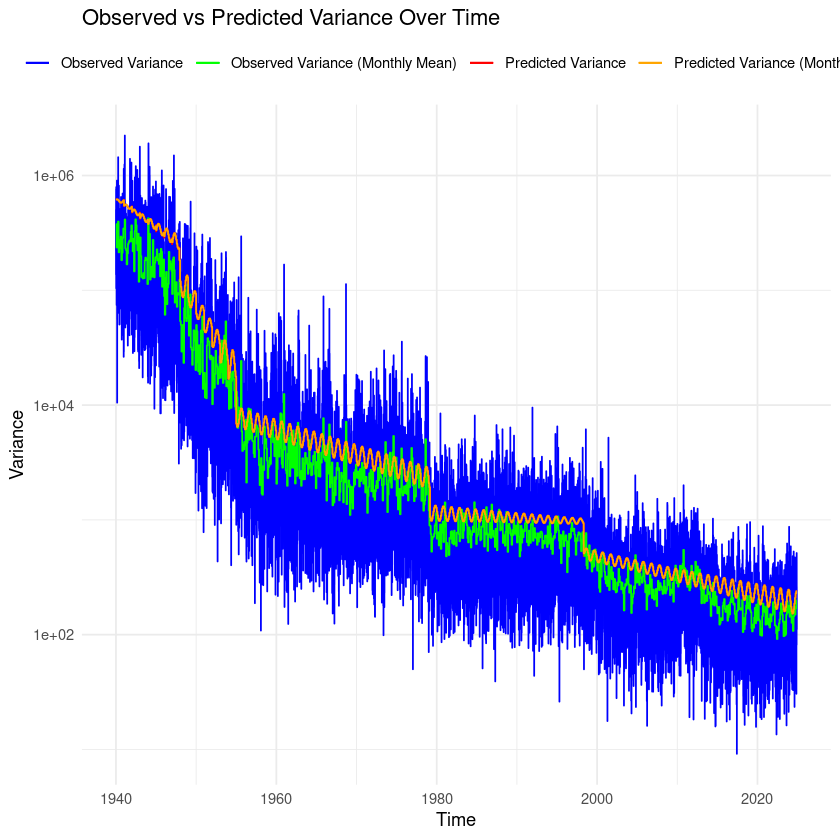

In [77]:
ggplot(variance_comparison, aes(x = time)) +
    geom_line(aes(
        y = observed_variance,
        color = "Observed Variance"
    ), size = .5) +
    geom_line(aes(
        y = predicted_variance,
        color = "Predicted Variance"
    ), size = .5) +
    geom_line(aes(
        y = monthly_observed_mean,
        color = "Observed Variance (Monthly Mean)"
    ), size = .5) +
    geom_line(aes(
        y = monthly_predicted_mean,
        color = "Predicted Variance (Monthly Mean)"
    ), size = .5) +
    scale_y_log10() +
    labs(
        title = "Observed vs Predicted Variance Over Time",
        x = "Time",
        y = "Variance",
        color = "Legend"
    ) +
    theme_minimal() +
    scale_color_manual(values = c(
        "Observed Variance" = "blue",
        "Predicted Variance" = "red",
        "Observed Variance (Monthly Mean)" = "green",
        "Predicted Variance (Monthly Mean)" = "orange"
    )) +
    theme(
        legend.position = "top",
        legend.title = element_blank()
    )


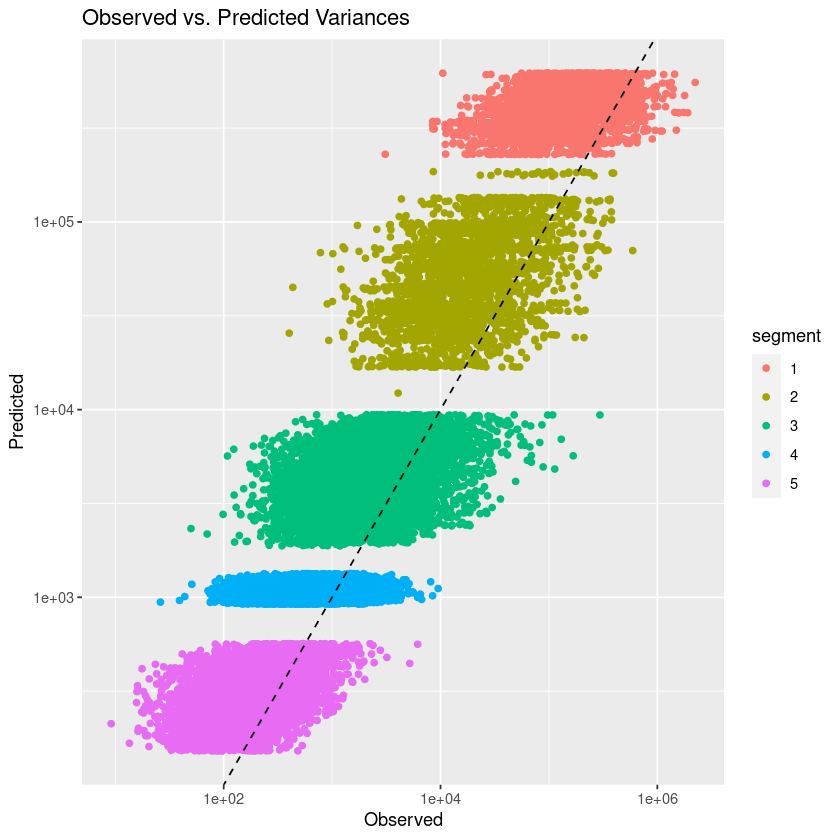

In [78]:
ggplot(data = variance_comparison, aes(
    x = observed_variance,
    y = predicted_variance,
    color = segment
)) +
    geom_point() +
    scale_y_log10() +
    scale_x_log10() +
    labs(
        title = "Observed vs. Predicted Variances", x = "Observed",
        y = "Predicted"
    ) +
    geom_abline(
        intercept = 0, slope = 1,
        linetype = "dashed", color = "black"
    )


## Model variance directly

GAMLSS-RS iteration 1: Global Deviance = 70741.61 
GAMLSS-RS iteration 2: Global Deviance = 70741.61 
******************************************************************
	      Summary of the Quantile Residuals
                           mean   =  -8.943865e-15 
                       variance   =  1.000032 
               coef. of skewness  =  0.09326727 
               coef. of kurtosis  =  3.712721 
Filliben correlation coefficient  =  0.9980512 
******************************************************************


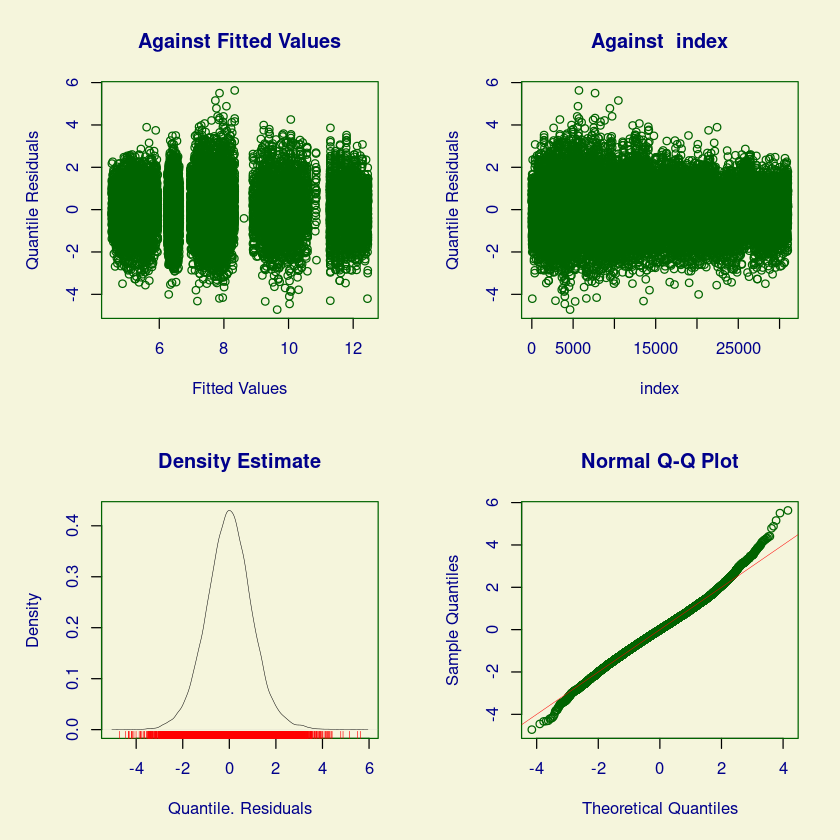

In [79]:
variance_comparison <- variance_comparison %>%
  mutate(
    year = year(time), # Extract year
    doy = yday(time), # Extract day of the year (1-366)
    log_variance = log(observed_variance), # Log-transform
    sin_doy = sin(2 * pi * doy / 365), # Sinusoidal component
    cos_doy = cos(2 * pi * doy / 365), # Cosine component
    segment = segment
  )

# Step 2: Define and Fit the GAMLSS Model
# Interaction between year, sin/cos(doy), and segment
model <- gamlss(
  log_variance ~ year * (sin_doy + cos_doy) * segment,
  family = NO, # Gaussian distribution for log-transformed variance
  data = variance_comparison
)

plot(model)


In [ ]:
predicted_var <-
    variance_comparison <- variance_comparison %>%
    mutate(
        predicted_log_variance = predict(model,
            what = "mu", type = "response"
        ), # Predicted log-variance
        predicted_variance = exp(predicted_log_variance) # Back-transform to variance
    )


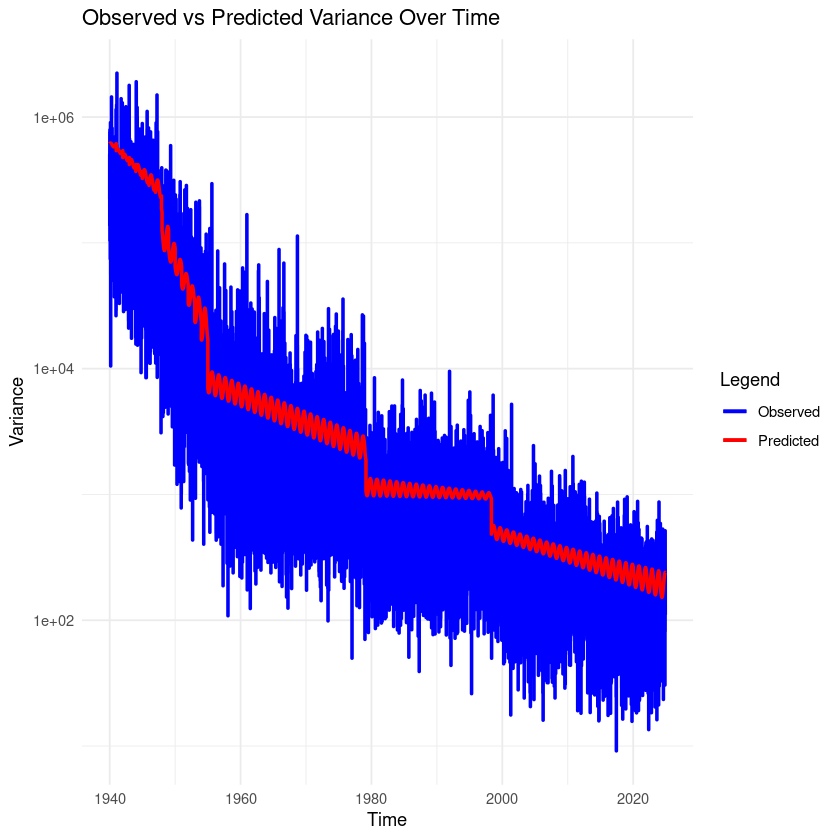

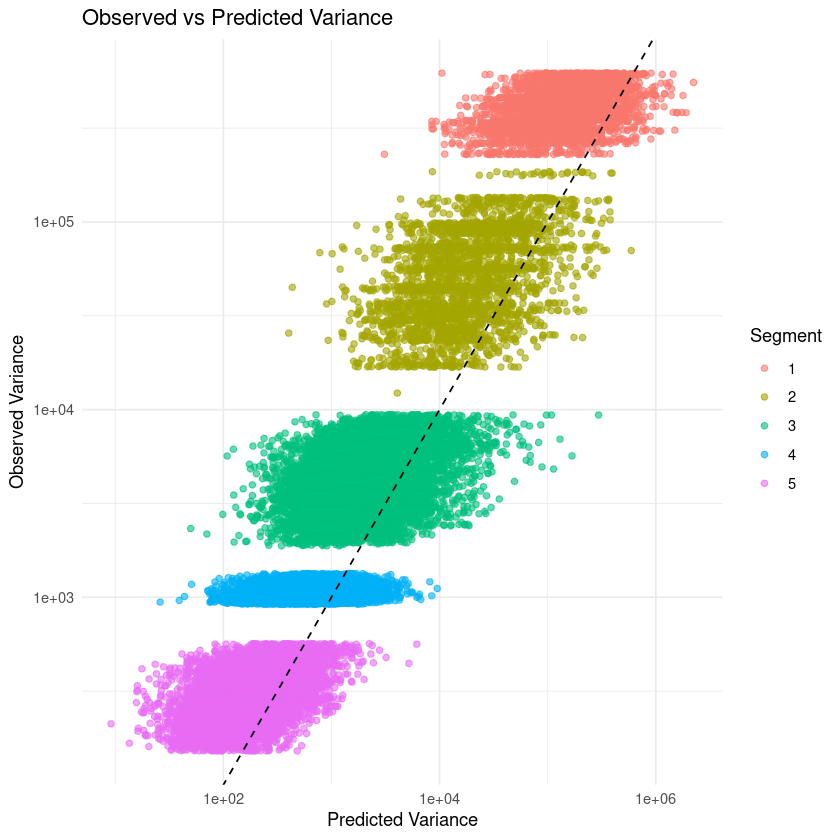

In [91]:
ggplot(variance_comparison, aes(x = time)) +
    geom_line(aes(y = observed_variance, color = "Observed"), size = 1) +
    geom_line(aes(y = predicted_variance, color = "Predicted"), size = 1) +
    scale_color_manual(values = c(
        "Observed" = "blue",
        "Predicted" = "red"
    )) +
    labs(
        title = "Observed vs Predicted Variance Over Time",
        x = "Time",
        y = "Variance",
        color = "Legend"
    ) +
    theme_minimal() +
    scale_y_log10()

# Step 3: Scatter Plot of Observed vs Predicted Variance
ggplot(variance_comparison, aes(
    x = observed_variance,
    y = predicted_variance, color = segment
)) +
    geom_point(alpha = 0.6) +
    geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "black") +
    labs(
        title = "Observed vs Predicted Variance",
        x = "Predicted Variance",
        y = "Observed Variance",
        color = "Segment"
    ) +
    theme_minimal() +
    scale_y_log10() +
    scale_x_log10()


## Simplest Model possible
- one segment only
- log(variance) directly
- linear model

`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


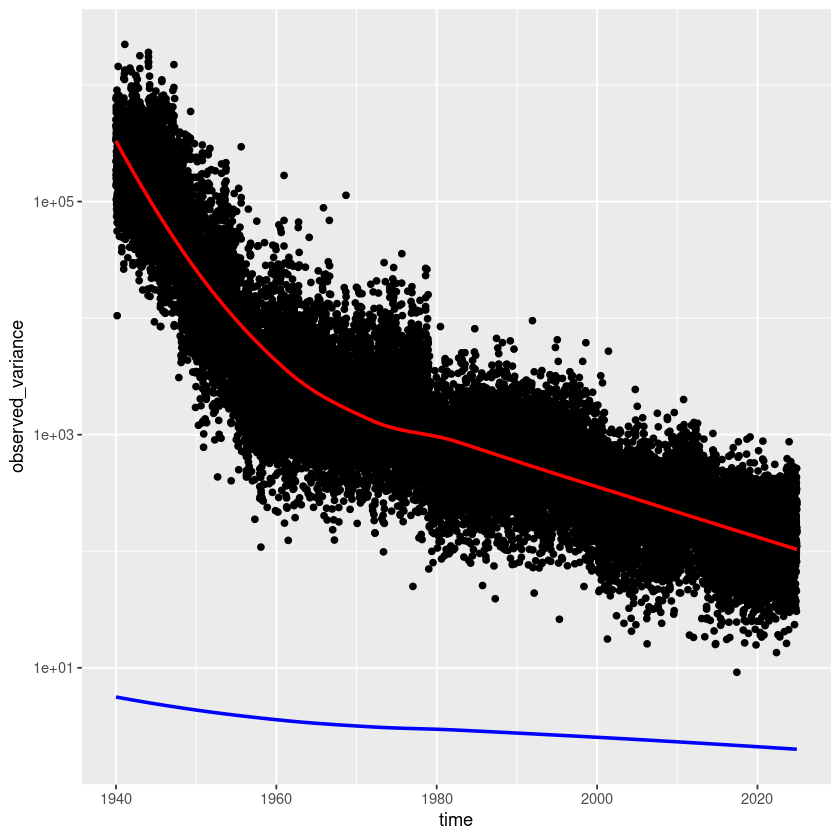

In [8]:
ggplot(observed_variance, aes(x = time, y = observed_variance)) +
    scale_y_log10() +
    geom_point() +
    geom_smooth(method = "loess", color = "red") +
    geom_smooth(
        method = "loess", aes(y = log10(observed_variance)),
        color = "blue"
    )


In [10]:
obs_var <- observed_variance %>%
    mutate(
        year = year(time), # Extract year
        doy = yday(time), # Extract day of the year (1-366)
        log_variance = log(observed_variance), # Log-transform
        sin_doy = sin(2 * pi * doy / 365), # Sinusoidal component
        cos_doy = cos(2 * pi * doy / 365), # Cosine component
    )

obs_var$segment <- cut(as.Date(obs_var$time),
    breaks = c(as.Date(c(
        obs_var$time[1],
        change_points_date,
        obs_var$time[nrow(obs_var)]
    ))),
    labels = 0:(length(change_points_date)) + 1,
    include.lowest = TRUE,
    right = TRUE
)
str(obs_var)

quartiles <- obs_var %>%
    group_by(year) %>%
    summarize(
        Q1 = quantile(log_variance, 0.25, na.rm = TRUE),
        Median = quantile(log_variance, 0.50, na.rm = TRUE),
        Q3 = quantile(log_variance, 0.75, na.rm = TRUE)
    )


tibble [31,013 × 8] (S3: tbl_df/tbl/data.frame)
 $ time             : Date[1:31013], format: "1940-01-01" "1940-01-02" ...
 $ observed_variance: num [1:31013] 222377 505244 341506 137276 444357 ...
 $ year             : num [1:31013] 1940 1940 1940 1940 1940 1940 1940 1940 1940 1940 ...
 $ doy              : num [1:31013] 1 2 3 4 5 6 7 8 9 10 ...
 $ log_variance     : num [1:31013] 12.3 13.1 12.7 11.8 13 ...
 $ sin_doy          : num [1:31013] 0.0172 0.0344 0.0516 0.0688 0.086 ...
 $ cos_doy          : num [1:31013] 1 0.999 0.999 0.998 0.996 ...
 $ segment          : Factor w/ 5 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...


In [10]:
obs_var <- obs_var %>%
    mutate(year = as.Date(format(time, "%Y-01-01")))

# Ensure `year` in `quartiles` is a Date object
quartiles <- quartiles %>%
    mutate(year = as.Date(paste0(year, "-01-01")))

# Broadcast yearly quartile values to every day of the year in `obs_var`
obs_var <- obs_var %>%
    left_join(quartiles, by = "year")

obs_var$year <- year(obs_var$time)


In [18]:
lmod <- lm(log_variance ~ year * segment,
    data = obs_var
)

obs_var$predicted_log_variance <- predict(lmod,
    newdata = obs_var,
    interval = "prediction"
)

obs_var <- obs_var %>%
    mutate(
        Pred_Lower = predicted_log_variance[, "lwr"],
        Pred_Upper = predicted_log_variance[, "upr"],
        Pred_fit = predicted_log_variance[, "fit"]
    )
str(obs_var)


tibble [31,013 × 15] (S3: tbl_df/tbl/data.frame)
 $ time                  : Date[1:31013], format: "1940-01-01" "1940-01-02" ...
 $ observed_variance     : num [1:31013] 222377 505244 341506 137276 444357 ...
 $ year                  : num [1:31013] 1940 1940 1940 1940 1940 1940 1940 1940 1940 1940 ...
 $ doy                   : num [1:31013] 1 2 3 4 5 6 7 8 9 10 ...
 $ log_variance          : num [1:31013] 12.3 13.1 12.7 11.8 13 ...
 $ sin_doy               : num [1:31013] 0.0172 0.0344 0.0516 0.0688 0.086 ...
 $ cos_doy               : num [1:31013] 1 0.999 0.999 0.998 0.996 ...
 $ segment               : Factor w/ 5 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ Q1                    : Named num [1:31013] 11.9 11.9 11.9 11.9 11.9 ...
  ..- attr(*, "names")= chr [1:31013] "25%" "25%" "25%" "25%" ...
 $ Median                : Named num [1:31013] 12.4 12.4 12.4 12.4 12.4 ...
  ..- attr(*, "names")= chr [1:31013] "50%" "50%" "50%" "50%" ...
 $ Q3                    : Named num [

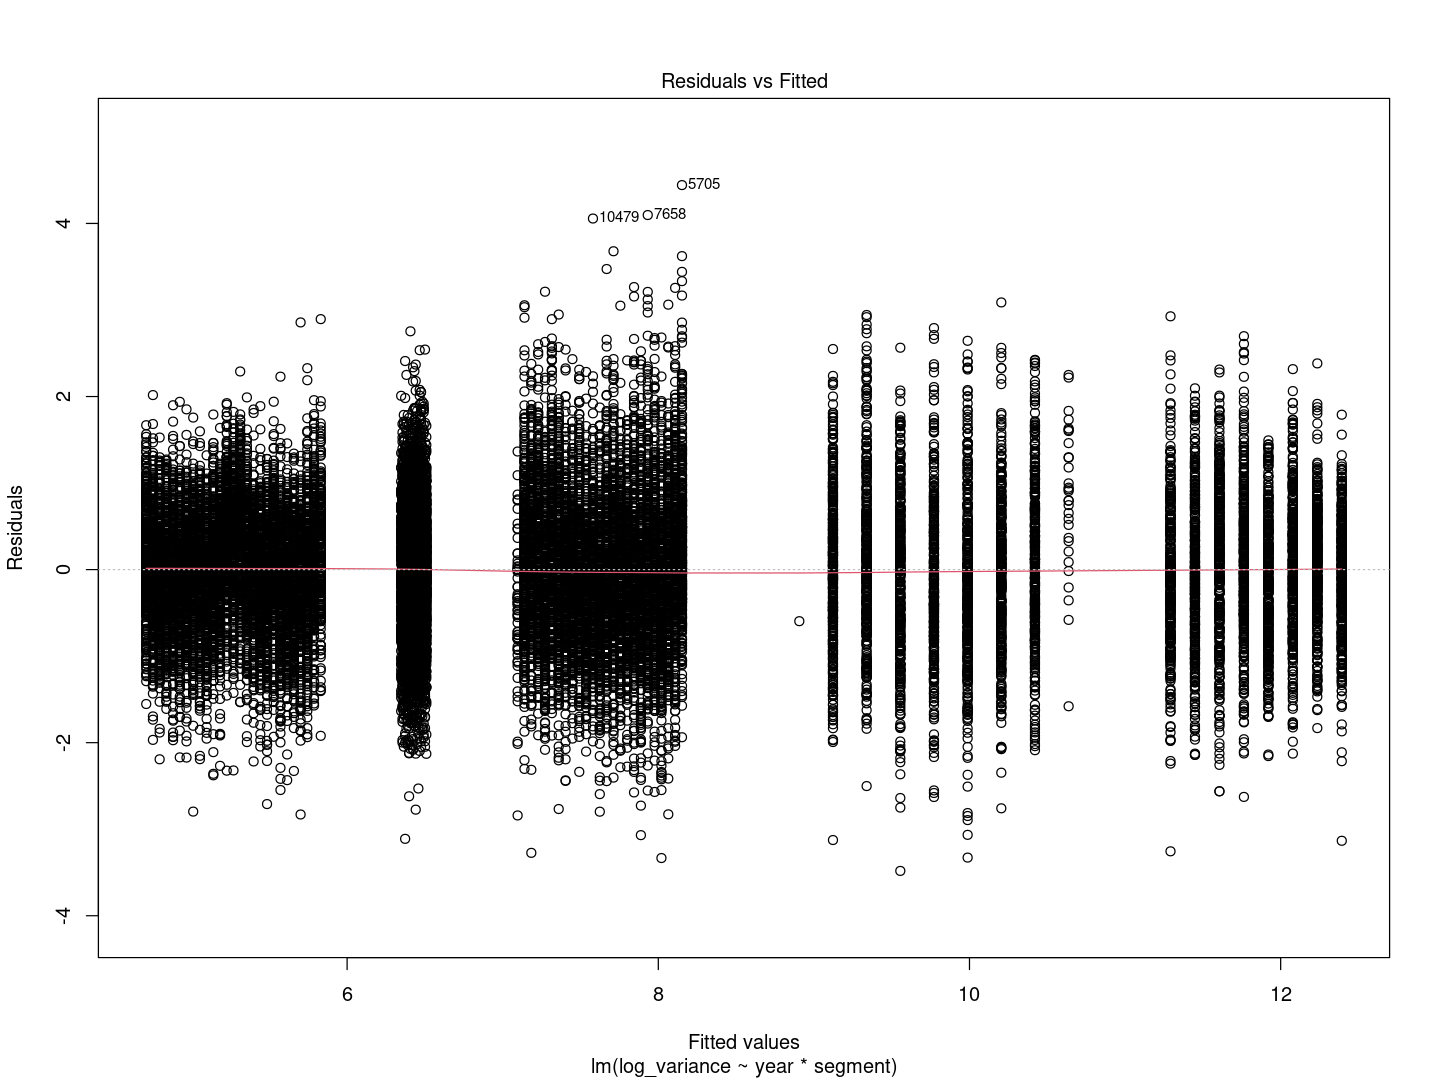

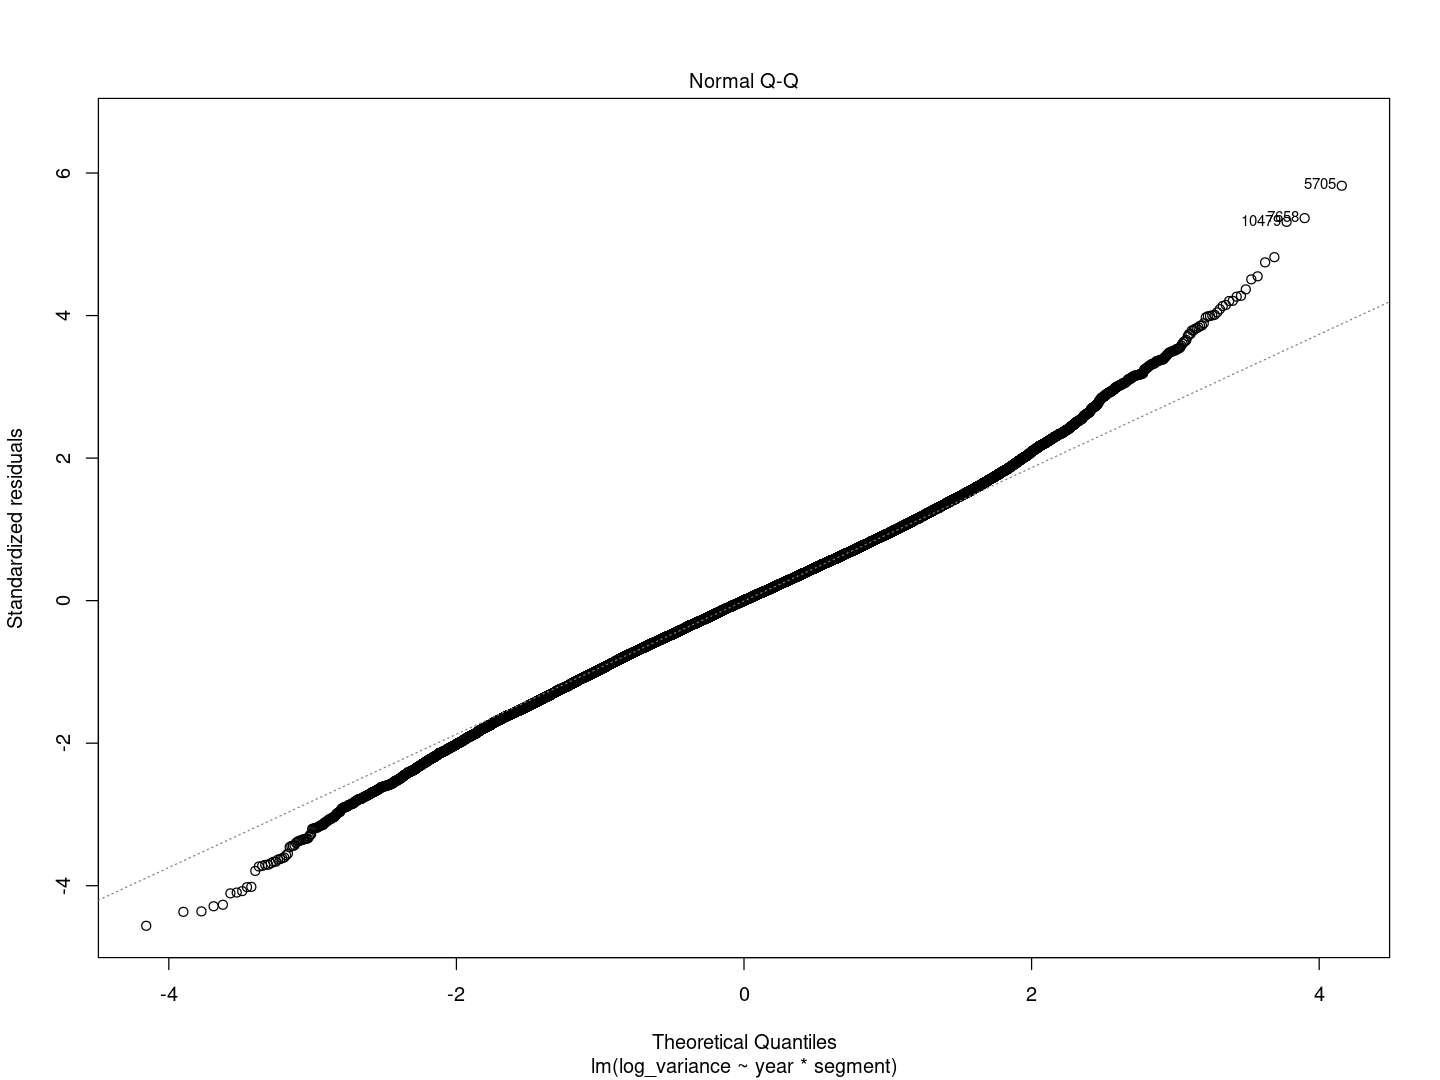

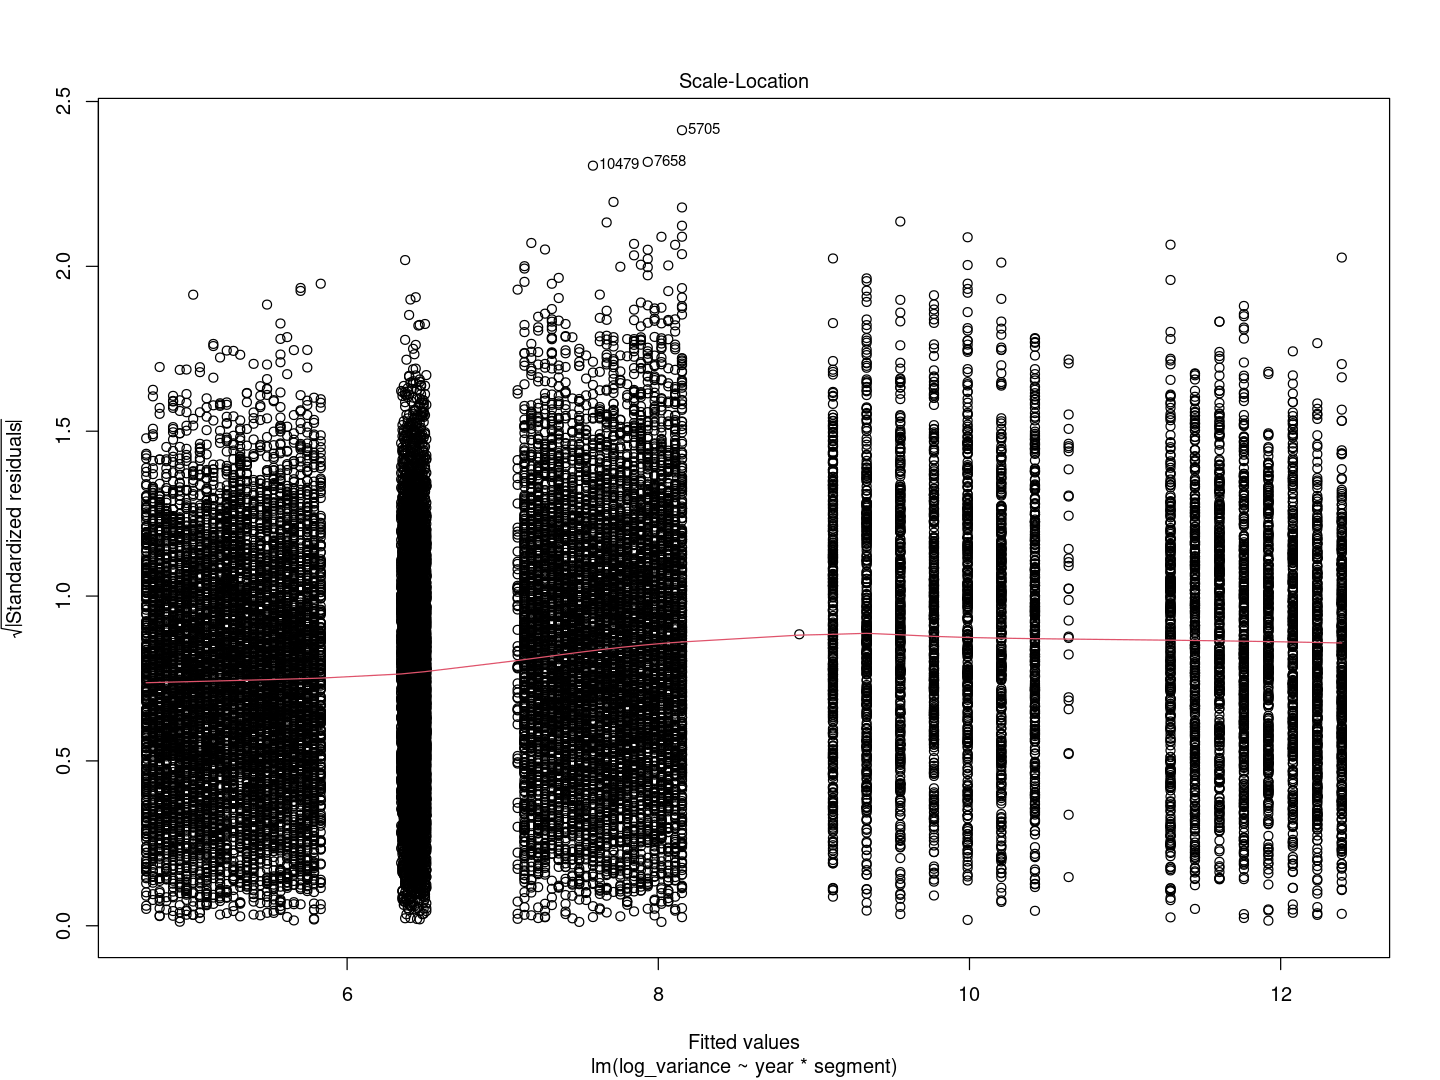


Call:
lm(formula = log_variance ~ year * segment, data = obs_var)

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4820 -0.4850  0.0007  0.4779  4.4434 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3.175e+02  1.213e+01  26.181  < 2e-16 ***
year          -1.573e-01  6.239e-03 -25.204  < 2e-16 ***
segment2       1.144e+02  1.881e+01   6.083 1.19e-09 ***
segment3      -2.233e+02  1.234e+01 -18.092  < 2e-16 ***
segment4      -2.941e+02  1.256e+01 -23.417  < 2e-16 ***
segment5      -2.254e+02  1.229e+01 -18.337  < 2e-16 ***
year:segment2 -5.912e-02  9.659e-03  -6.121 9.42e-10 ***
year:segment3  1.132e-01  6.347e-03  17.841  < 2e-16 ***
year:segment4  1.487e-01  6.453e-03  23.050  < 2e-16 ***
year:segment5  1.141e-01  6.320e-03  18.055  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.7634 on 31003 degrees of freedom
Multiple R-squared:  0.8735,	Adjusted R-squared:  0.8735 
F-statistic

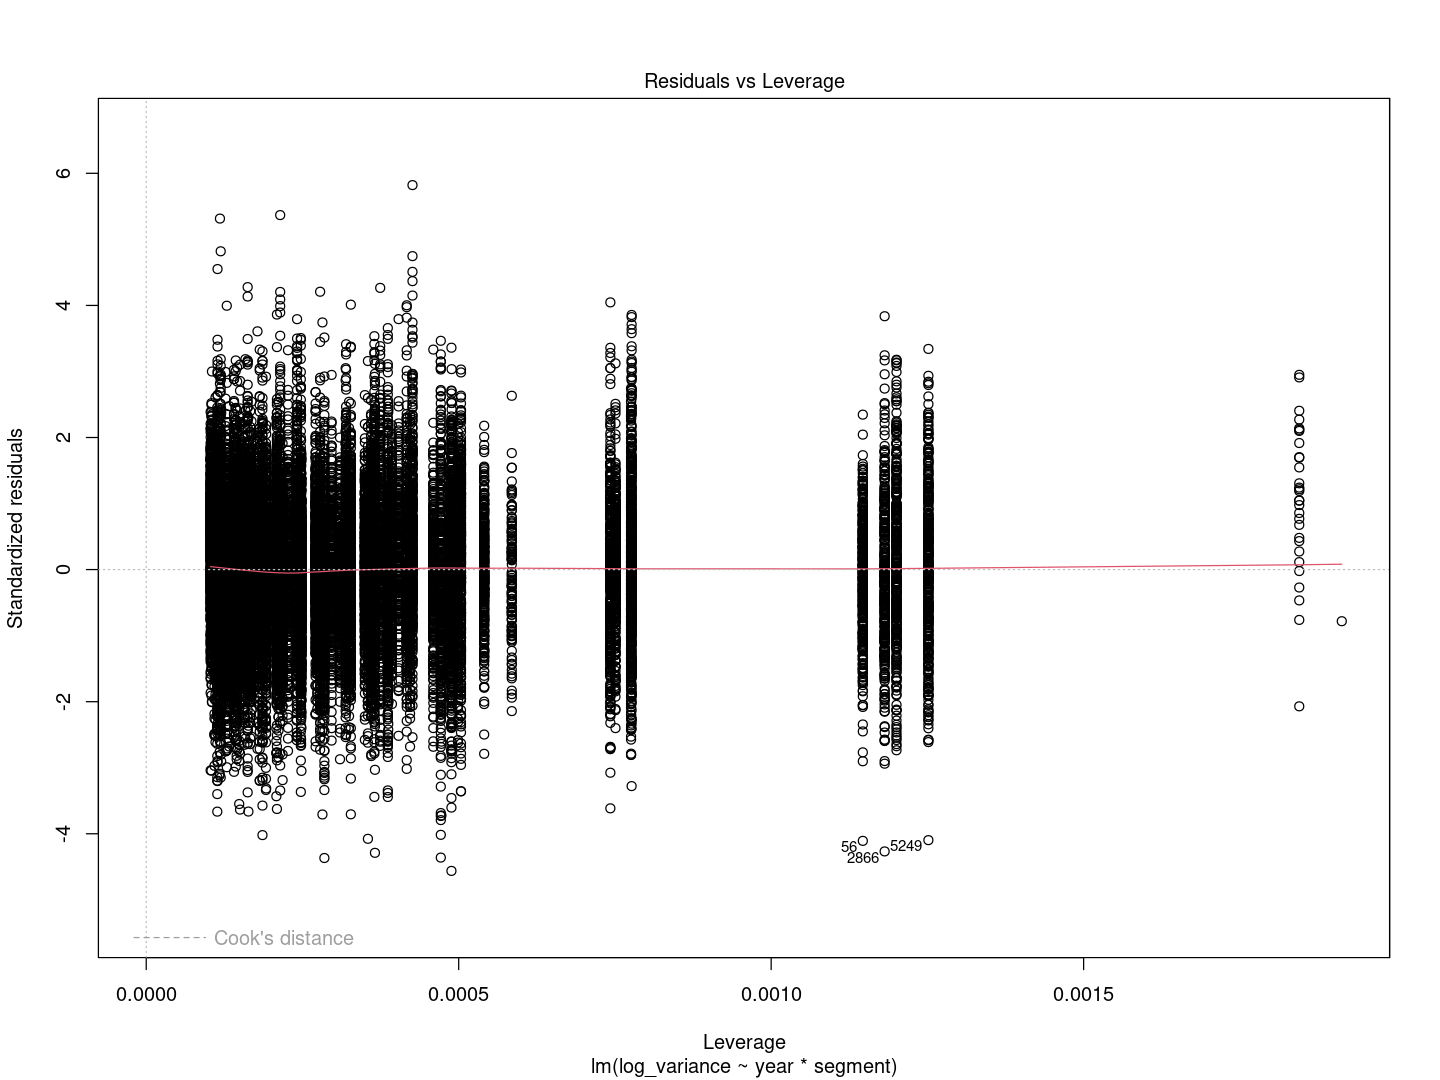

In [50]:
plot(lmod)
summary(lmod)


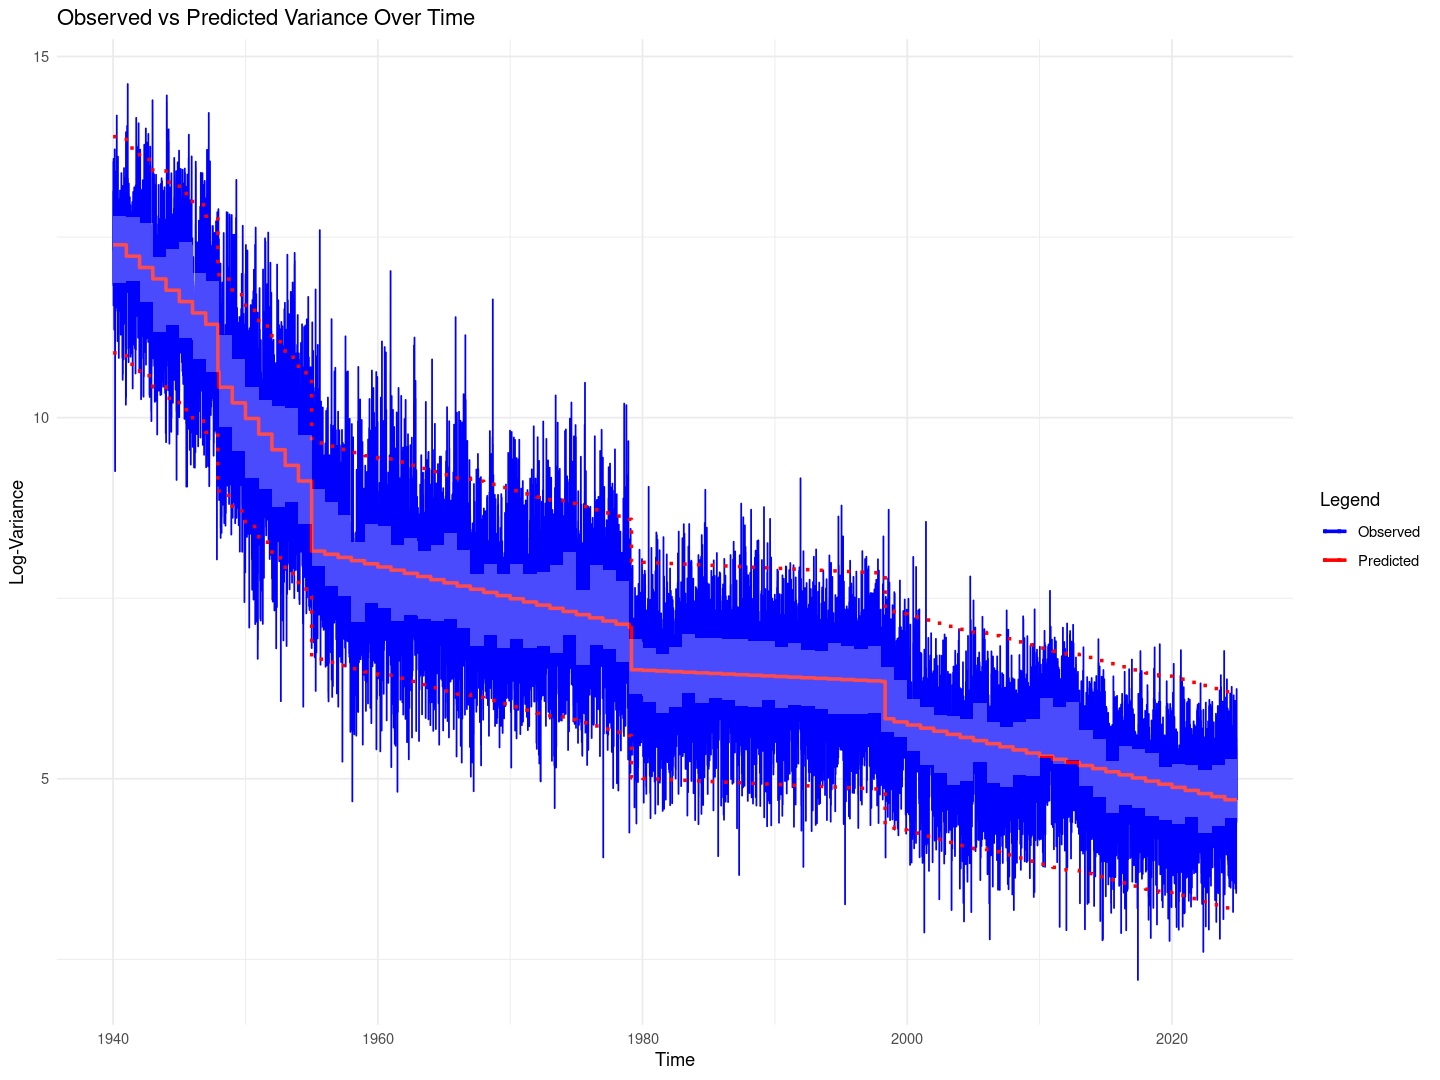

In [ ]:
options(repr.plot.width = 12, repr.plot.height = 9)
ggplot(obs_var, aes(x = time)) +
    geom_line(aes(y = log_variance, color = "Observed"), linewidth = .5) +
    geom_line(aes(y = Pred_fit, color = "Predicted"),
        linewidth = 1
    ) +
    geom_line(aes(y = Pred_Lower, color = "Predicted"),
        linewidth = 1, linetype = "dotted"
    ) +
    geom_line(aes(y = Pred_Upper, color = "Predicted"),
        linewidth = 1, linetype = "dotted"
    ) +
    geom_ribbon(aes(ymin = Q1, ymax = Q3),
        fill = "#fcfcfc", alpha = 0.3
    ) +
    scale_color_manual(values = c(
        "Observed" = "blue",
        "Predicted" = "red"
    )) +
    labs(
        title = "Observed vs Predicted Variance Over Time",
        x = "Time",
        y = "Log-Variance",
        color = "Legend"
    ) +
    theme_minimal()


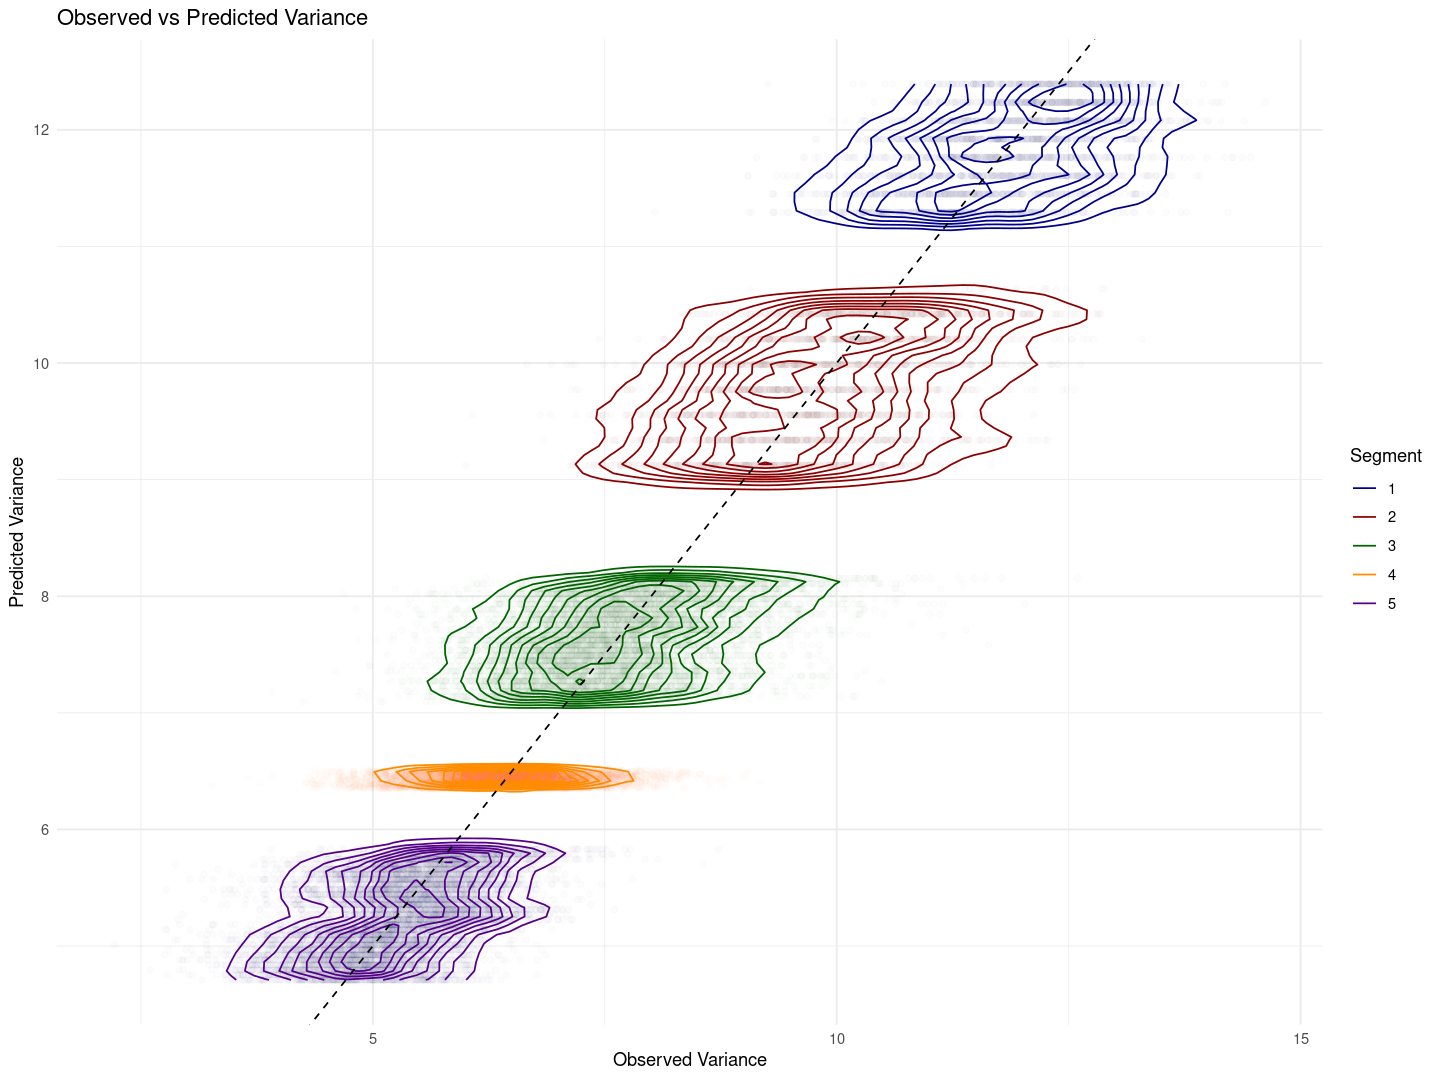

In [44]:
# Step 3: Scatter Plot of Observed vs Predicted Variance
ggplot(obs_var, aes(
    x = log_variance,
    y = Pred_fit, color = segment
)) +
    geom_point(alpha = 0.01) +
    geom_density_2d(alpha = 1, contour_var = "ndensity") +
    geom_abline(
        slope = 1, intercept = 0, linetype = "dashed",
        color = "black"
    ) +
    labs(
        title = "Observed vs Predicted Variance",
        x = "Observed Variance",
        y = "Predicted Variance",
        color = "Segment"
    ) +
    scale_color_manual(values = c(
        "1" = "darkblue",
        "2" = "darkred",
        "3" = "darkgreen",
        "4" = "darkorange",
        "5" = "#540088"
    )) +
    theme_minimal() #+
# scale_y_log10() +
# scale_x_log10()


In [11]:
obs_var_seas <- obs_var %>%
    mutate(yearmonth = floor_date(as.Date(time), "month"))

# Calculate quartiles on a yearmonth basis
quartiles <- obs_var_seas %>%
    group_by(yearmonth) %>%
    summarize(
        Q1 = quantile(log_variance, 0.25, na.rm = TRUE),
        Median = quantile(log_variance, 0.50, na.rm = TRUE),
        Q3 = quantile(log_variance, 0.75, na.rm = TRUE)
    )

obs_var_seas <- obs_var_seas %>%
    left_join(quartiles, by = "yearmonth")

str(obs_var_seas)


tibble [31,013 × 12] (S3: tbl_df/tbl/data.frame)
 $ time             : Date[1:31013], format: "1940-01-01" "1940-01-02" ...
 $ observed_variance: num [1:31013] 222377 505244 341506 137276 444357 ...
 $ year             : num [1:31013] 1940 1940 1940 1940 1940 1940 1940 1940 1940 1940 ...
 $ doy              : num [1:31013] 1 2 3 4 5 6 7 8 9 10 ...
 $ log_variance     : num [1:31013] 12.3 13.1 12.7 11.8 13 ...
 $ sin_doy          : num [1:31013] 0.0172 0.0344 0.0516 0.0688 0.086 ...
 $ cos_doy          : num [1:31013] 1 0.999 0.999 0.998 0.996 ...
 $ segment          : Factor w/ 5 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ yearmonth        : Date[1:31013], format: "1940-01-01" "1940-01-01" ...
 $ Q1               : Named num [1:31013] 12.2 12.2 12.2 12.2 12.2 ...
  ..- attr(*, "names")= chr [1:31013] "25%" "25%" "25%" "25%" ...
 $ Median           : Named num [1:31013] 12.8 12.8 12.8 12.8 12.8 ...
  ..- attr(*, "names")= chr [1:31013] "50%" "50%" "50%" "50%" ...
 $ Q3        

In [12]:
lmod_seas <- lm(log_variance ~ segment * year * (sin_doy + cos_doy) - 1,
    data = obs_var_seas
)

obs_var_seas$predicted_log_variance <- predict(lmod_seas,
    newdata = obs_var_seas,
    interval = "prediction"
)

obs_var_seas <- obs_var_seas %>%
    mutate(
        Pred_Lower = predicted_log_variance[, "lwr"],
        Pred_Upper = predicted_log_variance[, "upr"],
        Pred_fit = predicted_log_variance[, "fit"]
    )
str(obs_var_seas)


tibble [31,013 × 16] (S3: tbl_df/tbl/data.frame)
 $ time                  : Date[1:31013], format: "1940-01-01" "1940-01-02" ...
 $ observed_variance     : num [1:31013] 222377 505244 341506 137276 444357 ...
 $ year                  : num [1:31013] 1940 1940 1940 1940 1940 1940 1940 1940 1940 1940 ...
 $ doy                   : num [1:31013] 1 2 3 4 5 6 7 8 9 10 ...
 $ log_variance          : num [1:31013] 12.3 13.1 12.7 11.8 13 ...
 $ sin_doy               : num [1:31013] 0.0172 0.0344 0.0516 0.0688 0.086 ...
 $ cos_doy               : num [1:31013] 1 0.999 0.999 0.998 0.996 ...
 $ segment               : Factor w/ 5 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ yearmonth             : Date[1:31013], format: "1940-01-01" "1940-01-01" ...
 $ Q1                    : Named num [1:31013] 12.2 12.2 12.2 12.2 12.2 ...
  ..- attr(*, "names")= chr [1:31013] "25%" "25%" "25%" "25%" ...
 $ Median                : Named num [1:31013] 12.8 12.8 12.8 12.8 12.8 ...
  ..- attr(*, "names")= 

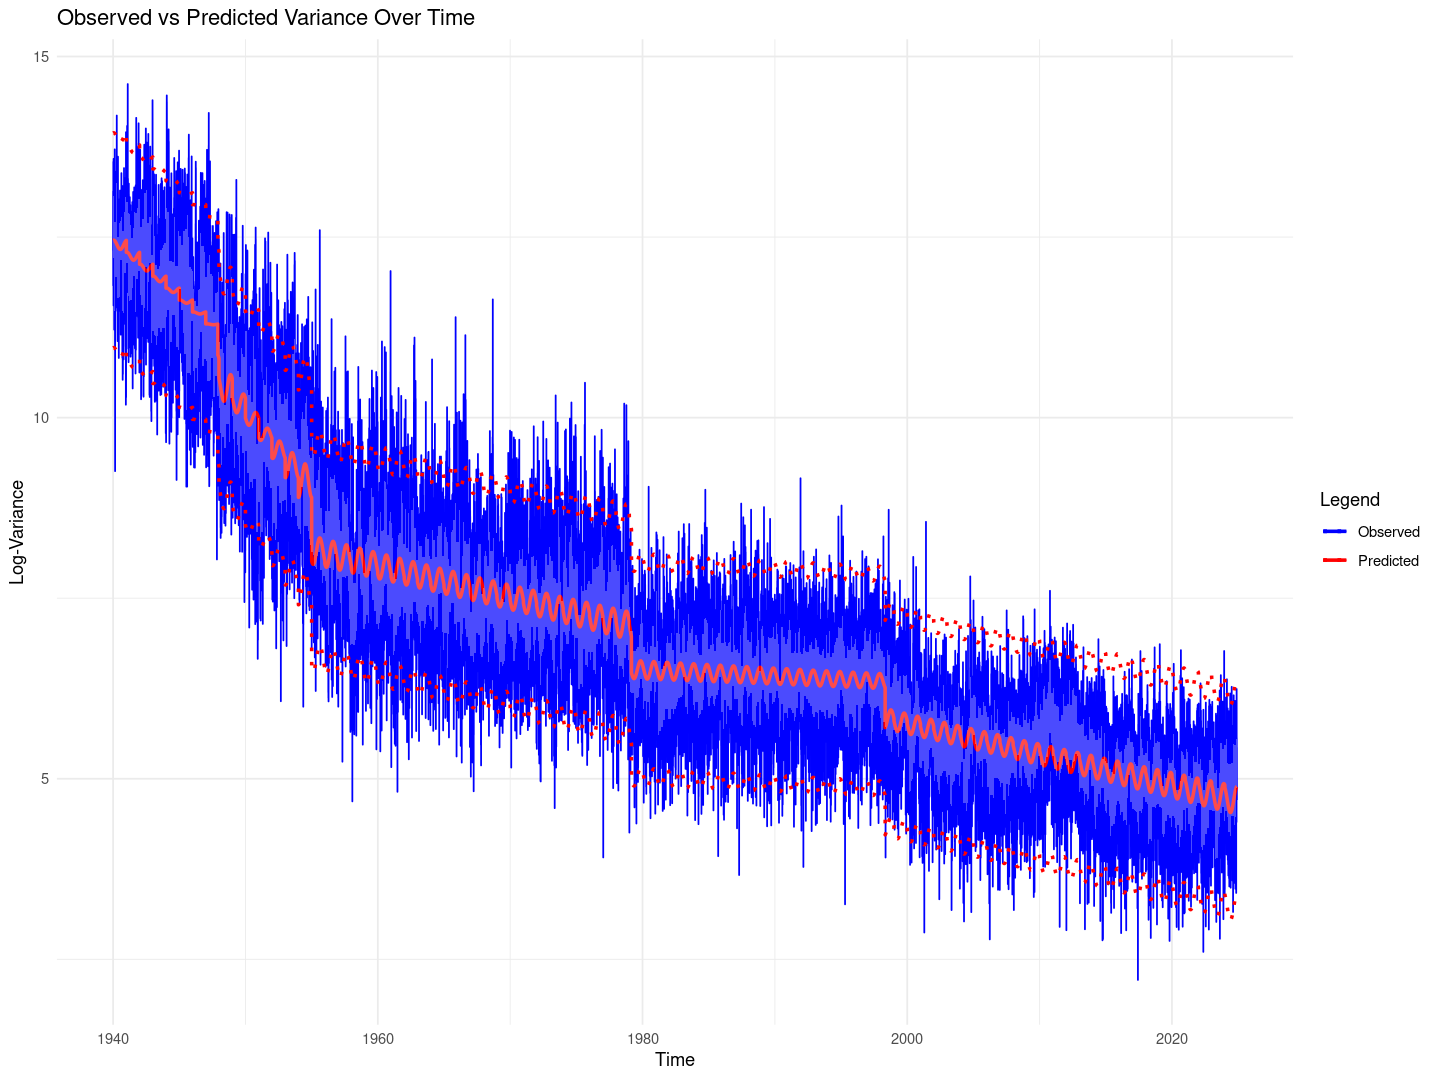

In [15]:
options(repr.plot.width = 12, repr.plot.height = 9)
ggplot(obs_var_seas, aes(x = time)) +
    geom_line(aes(y = log_variance, color = "Observed"), linewidth = .5) +
    geom_line(aes(y = Pred_fit, color = "Predicted"),
        linewidth = 1
    ) +
    geom_line(aes(y = Pred_Lower, color = "Predicted"),
        linewidth = 1, linetype = "dotted"
    ) +
    geom_line(aes(y = Pred_Upper, color = "Predicted"),
        linewidth = 1, linetype = "dotted"
    ) +
    geom_ribbon(aes(ymin = Q1, ymax = Q3),
        fill = "#fcfcfc", alpha = 0.3
    ) +
    scale_color_manual(values = c(
        "Observed" = "blue",
        "Predicted" = "red"
    )) +
    labs(
        title = "Observed vs Predicted Variance Over Time",
        x = "Time",
        y = "Log-Variance",
        color = "Legend"
    ) +
    theme_minimal()


## With Smoothing Splines now

In [ ]:
lmod_seas_smooth <- gam(
    log_variance ~ s(doy, by = segment, bs = "cc") +
        s(year, by = segment, bs = "cr") +
        ti(year, doy, by = segment, bs = c("cr", "cc")),
    data = obs_var_seas,
    method = "REML"
)

predictions <- predict(lmod_seas_smooth,
    newdata = obs_var_seas,
    se.fit = TRUE
)



# Extract residual standard deviation (sigma)
sigma <- sqrt(mean(residuals(lmod_seas_smooth)^2))

# Compute prediction intervals
obs_var_seas$predicted_log_variance <- predictions$fit
obs_var_seas$lower <- predictions$fit - 1.96 * sqrt(predictions$se.fit^2 + sigma^2)
obs_var_seas$upper <- predictions$fit + 1.96 * sqrt(predictions$se.fit^2 + sigma^2)


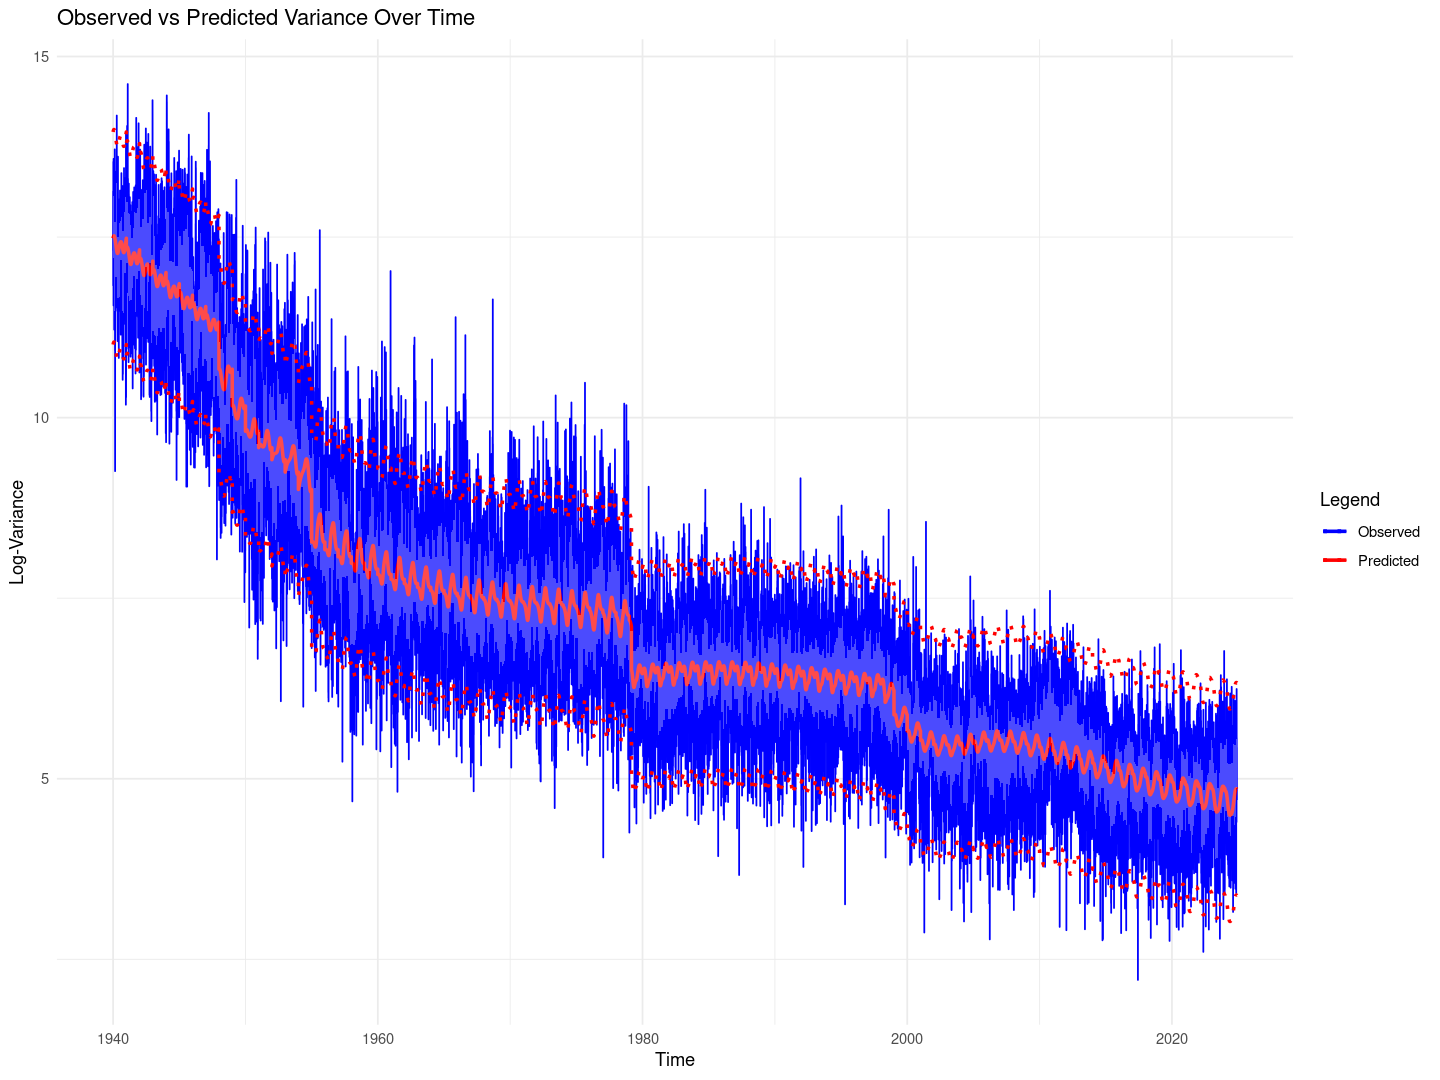

In [91]:
ggplot(obs_var_seas, aes(x = time)) +
    geom_line(aes(y = log_variance, color = "Observed"), linewidth = .5) +
    geom_line(aes(y = predicted_log_variance, color = "Predicted"),
        linewidth = 1
    ) +
    geom_line(aes(y = lower, color = "Predicted"),
        linewidth = 1, linetype = "dotted"
    ) +
    geom_line(aes(y = upper, color = "Predicted"),
        linewidth = 1, linetype = "dotted"
    ) +
    geom_ribbon(aes(ymin = Q1, ymax = Q3),
        fill = "#fcfcfc", alpha = 0.3
    ) +
    scale_color_manual(values = c(
        "Observed" = "blue",
        "Predicted" = "red"
    )) +
    labs(
        title = "Observed vs Predicted Variance Over Time",
        x = "Time",
        y = "Log-Variance",
        color = "Legend"
    ) +
    theme_minimal()


In [92]:
summary(lmod_seas_smooth)



Family: gaussian 
Link function: identity 

Formula:
log_variance ~ s(doy, by = segment, bs = "cc") + s(year, by = segment, 
    bs = "cr") + ti(year, doy, by = segment, bs = c("cr", "cc"))

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.1919     0.2139   28.94   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                         edf Ref.df       F  p-value    
s(doy):segment1       4.2463  8.000   2.553 1.37e-06 ***
s(doy):segment2       3.0594  8.000   1.782 9.72e-05 ***
s(doy):segment3       6.2160  8.000   9.242  < 2e-16 ***
s(doy):segment4       6.1517  8.000  10.926  < 2e-16 ***
s(doy):segment5       5.1553  8.000   3.014  < 2e-16 ***
s(year):segment1      1.5384  1.674 378.040  < 2e-16 ***
s(year):segment2      3.8182  3.967 303.683  < 2e-16 ***
s(year):segment3      4.5155  4.816 345.322  < 2e-16 ***
s(year):segment4      2.6091  3.008  14.139  < 2e-16 *

In [89]:
summary(lmod_seas_smooth)



Family: gaussian 
Link function: identity 

Formula:
log_variance ~ s(doy, by = segment, bs = "cc") + s(year, by = segment, 
    bs = "cr") + ti(year, doy, by = segment, bs = c("cr", "cc"))

Parametric coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)   6.2542     0.2562   24.41   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                          edf Ref.df       F  p-value    
s(doy):segment1       2.82764  8.000   2.575 2.25e-06 ***
s(doy):segment2       2.50494  8.000   1.732 8.25e-05 ***
s(doy):segment3       5.61079  8.000   9.494  < 2e-16 ***
s(doy):segment4       6.96090  8.000  13.593  < 2e-16 ***
s(doy):segment5       5.92277  8.000   3.138 3.11e-06 ***
s(year):segment1      2.73071  2.927 381.678  < 2e-16 ***
s(year):segment2      3.92917  3.995 282.374  < 2e-16 ***
s(year):segment3      6.92993  6.993 248.780  < 2e-16 ***
s(year):segment4      2.33191  2.692  10.144 

## Test with artificial data

In [101]:
# Set parameters
set.seed(123) # For reproducibility
num_years <- 7
num_points_per_day <- 9
days_per_year <- 365

# Generate the base dataset
z_df_test <- expand.grid(
    year = 1:num_years,
    day_of_year = 1:days_per_year,
    point = 1:num_points_per_day
) %>%
    mutate(
        # Create full date information
        time = as.Date(day_of_year - 1,
            origin = paste0(2000 + year, "-01-01")
        ),

        # Compute sine and cosine of day_of_year
        sin_doy = sin(2 * pi * day_of_year / days_per_year),
        cos_doy = cos(2 * pi * day_of_year / days_per_year),

        # Assign segment based on year
        segment = factor(ifelse(year <= 3, 1, 2))
    )

# Define variance function (log link ensures positive variance)
a <- 2 # Base variance
b <- 0.1 # Effect of year
c <- 0.5 # Effect of sin_doy
d <- 0.5 # Effect of cos_doy
e <- 1.5 # Effect of segment

# Compute variance and generate 'value'
z_df_test <- z_df_test %>%
    mutate(
        # Log-scale variance function
        log_sigma = (a + b * year + c * sin_doy + d * cos_doy +
            e * as.numeric(segment)),
        sigma = exp(log_sigma), # Back-transform to variance scale

        # Generate response value from zero-mean Gaussian with varying sigma
        value = rnorm(n(), mean = 0, sd = sigma)
    )

mod <- gamlss(
    value ~ year * (sin_doy + cos_doy) * segment,
    sigma.formula = ~ year * (sin_doy + cos_doy) * segment,
    data = z_df_test,
    family = NO(mu.link = "identity", sigma.link = "log"),
    trace = TRUE
)

# Number of bootstrap samples
n_boot <- 100

# Initialize list to store bootstrap predictions
bootstrap_variance <- list()

set.seed(123) # For reproducibility

# Bootstrap loop
for (i in 1:n_boot) {
    # Resample the data with replacement
    z_df_boot <- z_df_test[sample(nrow(z_df_test), replace = TRUE), ]

    # Refit the model on the resampled data
    mod_boot <- gamlss(
        value ~ year * (sin_doy + cos_doy) * segment,
        sigma.formula = ~ year * (sin_doy + cos_doy) * segment,
        data = z_df_boot,
        family = NO(mu.link = "identity", sigma.link = "log"),
        trace = FALSE
    )

    # Predict sigma for the original data
    sigma_boot <- predict(mod_boot,
        newdata = z_df_test, what = "sigma",
        type = "response"
    )

    # Store the variance (sigma^2)
    bootstrap_variance[[i]] <- sigma_boot^2
}

# Combine bootstrap results into a dataframe
bootstrap_matrix <- do.call(cbind, bootstrap_variance)


GAMLSS-RS iteration 1: Global Deviance = 284045.9 
GAMLSS-RS iteration 2: Global Deviance = 284039.1 
GAMLSS-RS iteration 3: Global Deviance = 284039.1 


In [102]:
# Compute prediction intervals for the variance
z_df_test <- z_df_test %>%
    mutate(
        predicted_variance = predict(mod, what = "sigma", type = "response")^2,
        lower_variance = apply(bootstrap_matrix, 1, quantile, probs = 0.025),
        upper_variance = apply(bootstrap_matrix, 1, quantile, probs = 0.975)
    )

# Compute observed variance by grouping over time
observed_variance <- z_df_test %>%
    group_by(time) %>%
    summarize(observed_variance = var(value, na.rm = TRUE))

# Summarize predicted variance over time
variance_summary <- z_df_test %>%
    group_by(time) %>%
    summarize(
        predicted_variance = mean(predicted_variance),
        lower_variance = mean(lower_variance),
        upper_variance = mean(upper_variance),
        segment = segment,
        true_variance = sigma^2
    ) %>%
    left_join(observed_variance, by = "time")


`summarise()` has grouped output by 'time'. You can override using the
`.groups` argument.


In [103]:
str(variance_summary)


gropd_df [22,995 × 7] (S3: grouped_df/tbl_df/tbl/data.frame)
 $ time              : Date[1:22995], format: "2001-01-01" "2001-01-01" ...
 $ predicted_variance: num [1:22995] 3860 3860 3860 3860 3860 ...
 $ lower_variance    : num [1:22995] 3589 3589 3589 3589 3589 ...
 $ upper_variance    : num [1:22995] 4174 4174 4174 4174 4174 ...
 $ segment           : Factor w/ 2 levels "1","2": 1 1 1 1 1 1 1 1 1 1 ...
 $ true_variance     : num [1:22995] 3704 3704 3704 3704 3704 ...
 $ observed_variance : num [1:22995] 5449 5449 5449 5449 5449 ...
 - attr(*, "groups")= tibble [2,555 × 2] (S3: tbl_df/tbl/data.frame)
  ..$ time : Date[1:2555], format: "2001-01-01" "2001-01-02" ...
  ..$ .rows: list<int> [1:2555] 
  .. ..$ : int [1:9] 1 2 3 4 5 6 7 8 9
  .. ..$ : int [1:9] 10 11 12 13 14 15 16 17 18
  .. ..$ : int [1:9] 19 20 21 22 23 24 25 26 27
  .. ..$ : int [1:9] 28 29 30 31 32 33 34 35 36
  .. ..$ : int [1:9] 37 38 39 40 41 42 43 44 45
  .. ..$ : int [1:9] 46 47 48 49 50 51 52 53 54
  .. ..$ : i

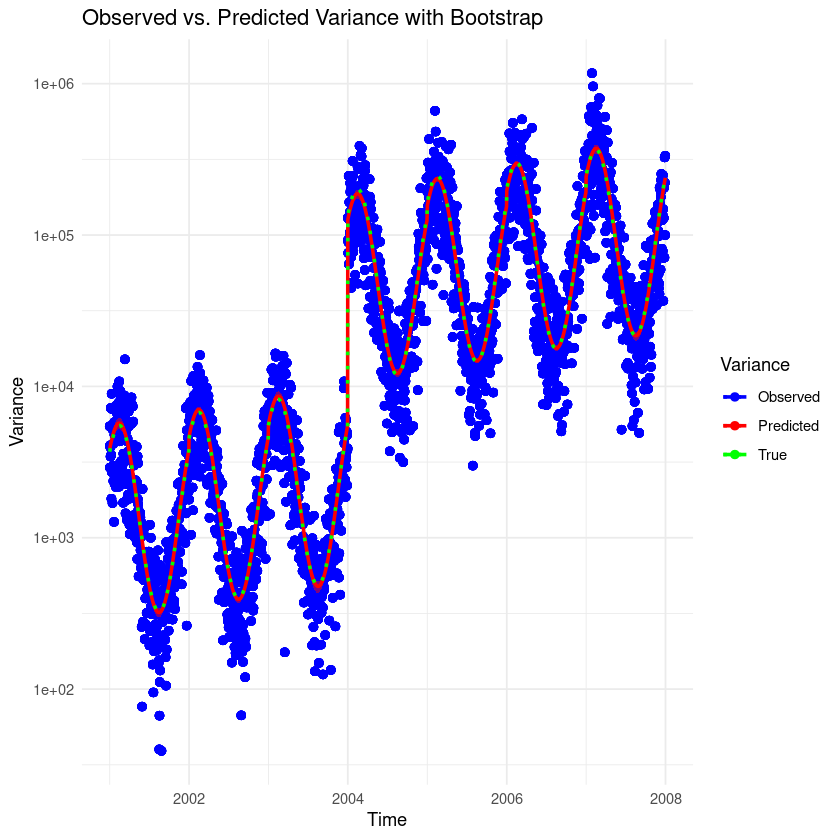

In [104]:
# Plot observed variance, predicted variance, and bootstrap intervals
ggplot(variance_summary, aes(x = time)) +
    geom_point(aes(y = observed_variance, color = "Observed"), size = 2) +
    # Add prediction intervals as a ribbon
    geom_ribbon(aes(ymin = lower_variance, ymax = upper_variance),
        fill = "#ff0202a1", alpha = 0.5
    ) +
    # Add predicted variance as a line
    geom_line(aes(y = predicted_variance, color = "Predicted"), size = 1) +
    geom_line(aes(y = true_variance, color = "True"),
        size = 1,
        linetype = "dotted"
    ) +
    labs(
        title = "Observed vs. Predicted Variance with Bootstrap",
        x = "Time",
        y = "Variance"
    ) +
    scale_color_manual(
        name = "Variance",
        values = c(
            "Observed" = "blue", "Predicted" = "red",
            "True" = "green"
        )
    ) +
    theme_minimal() +
    scale_y_log10()


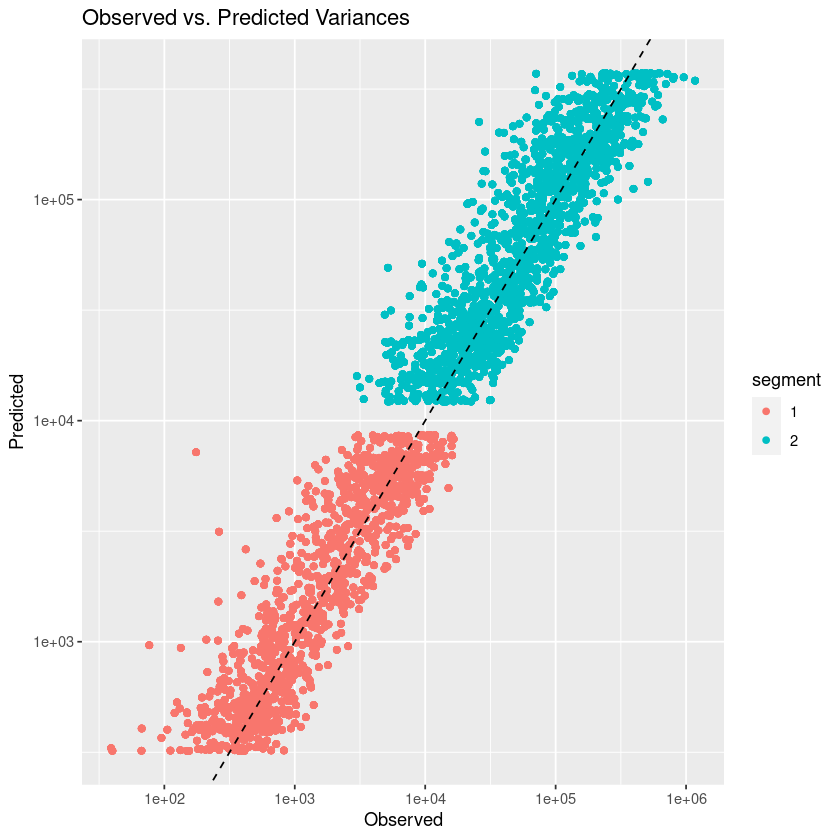

In [105]:
ggplot(data = variance_summary, aes(
    x = observed_variance,
    y = predicted_variance,
    color = segment
)) +
    geom_point() +
    scale_y_log10() +
    scale_x_log10() +
    labs(
        title = "Observed vs. Predicted Variances", x = "Observed",
        y = "Predicted"
    ) +
    geom_abline(
        intercept = 0, slope = 1,
        linetype = "dashed", color = "black"
    )


In [106]:
str(z_df)
str(z_df_test)


tibble [279,117 × 9] (S3: tbl_df/tbl/data.frame)
 $ time              : Date[1:279117], format: "1940-01-01" "1940-01-01" ...
 $ year              : int [1:279117] 1940 1940 1940 1940 1940 1940 1940 1940 1940 1940 ...
 $ doy               : int [1:279117] 1 1 1 1 1 1 1 1 1 2 ...
 $ member            : chr [1:279117] "z.2" "z.3" "z.4" "z.5" ...
 $ value             : num [1:279117] -68.6 271.4 -1089.6 -239.7 -292.2 ...
 $ sin_doy           : num [1:279117] 0.0172 0.0172 0.0172 0.0172 0.0172 ...
 $ cos_doy           : num [1:279117] 1 1 1 1 1 ...
 $ segment           : Factor w/ 5 levels "1","2","3","4",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ predicted_variance: Named num [1:279117] 613551 613550 613550 613550 613550 ...
  ..- attr(*, "names")= chr [1:279117] "1" "2" "3" "4" ...


'data.frame':	22995 obs. of  13 variables:
 $ year              : int  1 2 3 4 5 6 7 1 2 3 ...
 $ day_of_year       : int  1 1 1 1 1 1 1 2 2 2 ...
 $ point             : int  1 1 1 1 1 1 1 1 1 1 ...
 $ time              : Date, format: "2001-01-01" "2002-01-01" ...
 $ sin_doy           : num  0.0172 0.0172 0.0172 0.0172 0.0172 ...
 $ cos_doy           : num  1 1 1 1 1 ...
 $ segment           : Factor w/ 2 levels "1","2": 1 1 1 2 2 2 2 1 1 1 ...
 $ log_sigma         : num  4.11 4.21 4.31 5.91 6.01 ...
 $ sigma             : num  60.9 67.3 74.3 368.2 406.9 ...
 $ value             : num  -34.1 -15.5 115.9 26 52.6 ...
 $ predicted_variance: Named num  3860 4651 5603 126396 157144 ...
  ..- attr(*, "names")= chr [1:22995] "1" "2" "3" "4" ...
 $ lower_variance    : num  3589 4438 5227 118650 149394 ...
 $ upper_variance    : num  4174 4891 6015 133716 162603 ...
 - attr(*, "out.attrs")=List of 2
  ..$ dim     : Named int [1:3] 7 365 9
  .. ..- attr(*, "names")= chr [1:3] "year" "day_of_yea

In [35]:
library(ncdf4)
library(tidync)
library(mgcv)
library(tidyr)
library(lubridate)
library(dplyr)

# Constants
FILE <- "/net/scratch/schoelleh96/WP2/WP2.2a/ens_data/data.nc"
CP <- c("1947-12", "1955-01", "1979-03", "1998-05")
OUT_DIR <- "/net/scratch/schoelleh96/WP2/WP2.2a/ens_data/mods/"

# Read in the data
dims <- tidync(FILE)$dimension
time_steps <- filter(dims, name == "time") %>% pull(length)
lat_steps <- filter(dims, name == "latitude") %>% pull(length)
lon_steps <- filter(dims, name == "longitude") %>% pull(length)

nc_file <- nc_open(FILE)

z <- ncvar_get(
    nc_file,
    "z",
    start = c(1, 1, 1, 1),
    count = c(2, 2, 31013, 10)
)
# Get coordinates
lon_data <- ncvar_get(nc_file, "longitude", count = lon_steps)
lat_data <- ncvar_get(nc_file, "latitude", count = lat_steps)
grid_points <- expand.grid(lon_data, lat_data)

time_data <- ncvar_get(nc_file, "valid_time", count = time_steps)

# Convert time
time_origin <- sub(
    "seconds since ", "",
    ncatt_get(nc_file, "valid_time", "units")$value
)
time <- as.Date(as.POSIXct(time_data, origin = time_origin, tz = "UTC"))

nc_close(nc_file)

# Change points
# Convert to Date objects for easier comparison
change_points <- as.Date(paste0(CP, "-01"), format = "%Y-%m-%d")


In [37]:
str(z)
str(z[1, 1, , ])


 num [1:2, 1:2, 1:31013, 1:10] 52006 52006 52237 52237 50273 ...
 num [1:31013, 1:10] 52006 50273 49992 50731 48786 ...


In [38]:
dims


id,name,length,unlim,coord_dim,active,start,count
<int>,<chr>,<dbl>,<lgl>,<lgl>,<lgl>,<int>,<int>
0,number,10,FALSE,TRUE,TRUE,1,10
1,time,31013,FALSE,TRUE,TRUE,1,31013
2,latitude,141,FALSE,TRUE,TRUE,1,141
3,longitude,241,FALSE,TRUE,TRUE,1,241


In [18]:
process_grid_point <- function(lat_idx, lon_idx, z, time, cps) {
    # pull data together

    z_df <- data.frame(time = time, z = z)
    z_df$year <- as.integer(format(z_df$time, "%Y"))
    z_df$doy <- as.integer(format(z_df$time, "%j"))

    z_df <- z_df %>%
        pivot_longer(
            cols = starts_with("z"), # Select all columns that are part of 'z'
            names_to = "member",
            values_to = "value"
        ) %>%
        group_by(time) %>% # Group by time to calculate differences per row
        mutate(
            value = if_else(
                member != "z.1", # If not 'z1',
                value - value[member == "z.1"], # Subtract 'z1' value
                value # Keep 'z1' values unchanged
            )
        ) %>%
        ungroup()

    z_df$sin_doy <- sin(2 * pi * z_df$doy / 365)
    z_df$cos_doy <- cos(2 * pi * z_df$doy / 365)

    z_df <- z_df %>% filter(member != "z.1")
    observed_variance <- z_df %>%
        group_by(time) %>%
        summarize(observed_variance = var(value, na.rm = TRUE)) %>%
        ungroup()

    observed_variance <- observed_variance %>%
        mutate(
            year = year(time), # Extract year
            doy = yday(time), # Extract day of the year (1-366)
            log_variance = log(observed_variance), # Log-transform
            sin_doy = sin(2 * pi * doy / 365), # Sinusoidal component
            cos_doy = cos(2 * pi * doy / 365), # Cosine component
        )
    observed_variance$segment <- cut(as.Date(observed_variance$time),
        breaks = c(as.Date(c(
            observed_variance$time[1],
            cps,
            observed_variance$time[nrow(observed_variance)]
        ))),
        labels = 0:(length(cps)) + 1,
        include.lowest = TRUE,
        right = TRUE
    )

    # Estimate linear model
    lmod_seas <- lm(log_variance ~ segment * year * (sin_doy + cos_doy) - 1,
        data = observed_variance
    )

    saveRDS(lmod_seas, file = paste0(
        OUT_DIR, "lm", lat_idx, "_", lon_idx,
        ".Rds"
    ))
    # Estimate smooth model
    lmod_seas_smooth <- gam(
        log_variance ~ s(doy, by = segment, bs = "cc") +
            s(year, by = segment, bs = "cr") +
            ti(year, doy, by = segment, bs = c("cr", "cc")),
        data = observed_variance
    )
    saveRDS(lmod_seas_smooth, file = paste0(
        OUT_DIR, "slm", lat_idx, "_", lon_idx,
        ".Rds"
    ))
}


In [19]:
process_grid_point(lat_idx = 1, lon_idx = 1, z = z, time = time, cps = cps)


In [33]:
str(z)


 num [1:31013, 1:10] 52006 50273 49992 50731 48786 ...


In [24]:
dims



Data Source (1): data.nc ...

Grids (5) <dimension family> : <associated variables> 

[1]   D3,D2,D1,D0 : z    **ACTIVE GRID** ( 10538527530  values per variable)
[2]   D0          : number
[3]   D1          : time, valid_time
[4]   D2          : latitude
[5]   D3          : longitude

Dimensions 4 (all active): 
  
  dim   name    length     min    max start count    dmin   dmax unlim coord_dim 
  <chr> <chr>    <dbl>   <dbl>  <dbl> <int> <int>   <dbl>  <dbl> <lgl> <lgl>     
1 D0    number      10  0      9   e0     1    10  0      9   e0 FALSE TRUE      
2 D1    time     31013 -9.47e8 1.73e9     1 31013 -9.47e8 1.73e9 FALSE TRUE      
3 D2    latitu…    141  2   e1 9   e1     1   141  2   e1 9   e1 FALSE TRUE      
4 D3    longit…    241 -1   e2 2   e1     1   241 -1   e2 2   e1 FALSE TRUE      

In [31]:
nc_file <- nc_open("/net/scratch/schoelleh96/WP2/WP2.2a/ens_data/data.nc")

# Get time
lat_dat <- ncvar_get(
    nc_file,
    "latitude",
    start = 1,
    count = lat_steps
)
nc_close(nc_file)

str(lat_dat)


 num [1:141(1d)] 90 89.5 89 88.5 88 87.5 87 86.5 86 85.5 ...


In [32]:
gridPoints <- expand.grid(lat_dat, lon_dat)
gridPoints


Var1,Var2
<dbl[1d]>,<dbl[1d]>
90.0,-100
89.5,-100
89.0,-100
88.5,-100
88.0,-100
87.5,-100
87.0,-100
86.5,-100
86.0,-100
